In [1]:
import os
import torch
import pandas as pd
from PIL import Image
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn.functional as f
from tqdm import tqdm


from networks.upscaler_resnet_larger_upscaler import UpscalerResNet
from torch.optim import SGD
from torch.optim import Adam
from torch.nn import MSELoss
from torch.nn import L1Loss

from data.memory_dataset import MemoryData
from data.ssd_dataset import SSDData
from data.random_position_selector import RandomPartSelector
from data.same_position_selector import SamePartSelector
import torchvision.transforms.v2 as transforms

Image.MAX_IMAGE_PIXELS = None

%load_ext autoreload
%autoreload 2

In [14]:
train_transform = transforms.Compose(
    [RandomPartSelector(minimum_size=512, output_size=512),]

)

val_transform = SamePartSelector(output_size=512)





device = "cuda"

In [3]:
hp={
    "n1" : 32,
    "n2" : 64,
    "n3" : 128,
    "n4" : 256,
    "n5" : 256,
    "u4" : 256,
    "u3" : 256,
    "u2" : 256,
    "u1" : 256,
    "interface" : 128,
    "nupscaler" : 128
}

model = UpscalerResNet(hp=hp)

model.to(device)

parameter_list = list(model.upscaler.parameters()) + list(model.unet_backbone.parameters())

optimizer = Adam(parameter_list, lr=3e-4)


train_losses = []
val_losses = []

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

num_parameters_upscaler = count_parameters(model.upscaler)
num_parameters_unet = count_parameters(model.unet_backbone)

batch_size = 1


print("Upscaler has {} parameters\nUnet has {} parameters".format(num_parameters_upscaler, num_parameters_unet))

/home/daniel/anaconda3/envs/i2dl/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/daniel/anaconda3/envs/i2dl/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Upscaler has 134659 parameters
Unet has 1590880 parameters


In [4]:
#loss_func = MSELoss()
loss_func = L1Loss()
optimizer.lr = 5e-2
#optimizer.lr = 1e-2
#optimizer.lr = 1e-3
#optimizer.lr = 3e-4
#optimizer.lr = 5e-5

In [5]:

import gc

#optimizer.lr=1e-3
def train(model, epochs, train_loader, val_loader):
    model.to(device)
    for epoch in range(epochs):
        bar = tqdm(zip(range(len(train_loader)), train_loader), total=len(train_loader), desc="train {:0>5}".format(epoch + 1), ncols=100)
        train_loss_sum = 0
        val_loss_sum = 0
        for i, batch in bar:
            down_image, target = batch
            
        
            #down_image = f.interpolate(gpu_batch, scale_factor=(.5, .5), mode="bilinear", antialias=True)
            with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
                model.train()
                down_image = down_image.to(device)
                model.zero_grad()
                prediction = model.forward(down_image)
        

                #target = (gpu_batch - f.interpolate(down_image, scale_factor=(2,2), mode="bilinear"))*2
                del down_image
                target = target.to(device)
                loss = loss_func(prediction, target)

                del target
                del prediction
                loss.backward()
                train_loss_sum += loss.item()
        
                optimizer.step()
            bar.set_postfix(loss = "{:.8f}".format(train_loss_sum / (i + 1)))

        

        
        train_losses.append(train_loss_sum / np.max([len(train_loader), 1]))
        gc.collect()
        torch.cuda.empty_cache()
        model.eval()
        bar = tqdm(zip(range(len(val_loader)), val_loader), total=len(val_loader), desc="val {:0>5}".format(epoch + 1), ncols=100)
        for i, batch in bar:
            down_image, target = batch
            #down_image = f.interpolate(gpu_batch, scale_factor=(.5, .5), mode="bilinear", antialias=True)
            with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
                down_image, target = down_image.to(device), target.to(device)
                prediction = model.forward(down_image)
        
                #target = (gpu_batch - f.interpolate(down_image, scale_factor=(2,2), mode="bilinear"))*2
                del down_image
                loss = loss_func(prediction, target)
                val_loss_sum += loss.item()
        
                bar.set_postfix(loss = "{:.8f}".format(val_loss_sum / (i+ 1)))
        
        
                #del gpu_batch
                del target
                del prediction
        val_losses.append(val_loss_sum /np.max([len(val_loader), 1]))
        #optimizer.lr = optimizer.lr * .98
    
    #model.eval()
    #prediction = model.forward(val_down_image)
    #loss = loss_func(prediction, val_target)
    #val_losses.append(loss.item())
    


In [57]:
val_set = SSDData("data/perspective", val_transform, start=330, size=2)
train_set = SSDData("data/perspective", val_transform, 0, 1)

train_loader = DataLoader(train_set, batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_set, batch_size, drop_last=True)
val_loader = []


#300
optimizer.lr = 2e-1
train(model, 300, train_loader, val_loader)

357
357


train 00001:   0%|                                                            | 0/1 [00:00<?, ?it/s]

train 00001: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  3.43it/s, loss=0.04925535]
val 00001: 0it [00:00, ?it/s]
train 00002: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  5.98it/s, loss=0.04583123]
val 00002: 0it [00:00, ?it/s]
train 00003: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  6.13it/s, loss=0.04353745]
val 00003: 0it [00:00, ?it/s]
train 00004: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  6.18it/s, loss=0.04198584]
val 00004: 0it [00:00, ?it/s]
train 00005: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  6.13it/s, loss=0.04175609]
val 00005: 0it [00:00, ?it/s]
train 00006: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  6.18it/s, loss=0.04241331]
val 00006: 0it [00:00, ?it/s]
train 00007: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  6.20it/s, loss=0.04273021]
val 00007: 0it [00:00, ?it/s]
train 00008: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  6.01it/s,

In [60]:
#900
optimizer.lr = 1e-1
train(model, 900, train_loader, val_loader)

train 00001: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  2.70it/s, loss=0.03591346]
val 00001: 0it [00:00, ?it/s]
train 00002: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  6.10it/s, loss=0.03586341]
val 00002: 0it [00:00, ?it/s]
train 00003: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  6.22it/s, loss=0.03574490]
val 00003: 0it [00:00, ?it/s]
train 00004: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  6.06it/s, loss=0.03574201]
val 00004: 0it [00:00, ?it/s]
train 00005: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  6.24it/s, loss=0.03569098]
val 00005: 0it [00:00, ?it/s]
train 00006: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  6.21it/s, loss=0.03562022]
val 00006: 0it [00:00, ?it/s]
train 00007: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  6.23it/s, loss=0.03562094]
val 00007: 0it [00:00, ?it/s]
train 00008: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  6.18it/s,

In [24]:
#1000
optimizer.lr = 5e-2
train(model, 1000, train_loader, val_loader)

train 00001: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s, loss=0.01941827]
val 00001: 0it [00:00, ?it/s]
train 00002: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  6.32it/s, loss=0.01933705]
val 00002: 0it [00:00, ?it/s]
train 00003: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  6.30it/s, loss=0.01952498]
val 00003: 0it [00:00, ?it/s]
train 00004: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  6.20it/s, loss=0.01966774]
val 00004: 0it [00:00, ?it/s]
train 00005: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  6.37it/s, loss=0.01948294]
val 00005: 0it [00:00, ?it/s]
train 00006: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  6.42it/s, loss=0.01974263]
val 00006: 0it [00:00, ?it/s]
train 00007: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  6.42it/s, loss=0.01916241]
val 00007: 0it [00:00, ?it/s]
train 00008: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  6.41it/s,

In [21]:
model = torch.load("PerspectiveNetRESBackbone64V1.pt")
parameter_list = list(model.upscaler.parameters()) + list(model.unet_backbone.parameters())

optimizer = Adam(parameter_list, lr=3e-4)


In [22]:
val_set = SSDData("data/perspective", val_transform, start=330, size=24)
train_set = SSDData("data/perspective", train_transform, 0, 330)

batch_size = 4
train_loader = DataLoader(train_set, batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_set, batch_size, drop_last=True)

357
357


In [24]:
optimizer.lr = 1e-2
train(model, 40, train_loader, val_loader)

val 00040: 100%|█████████████████████████████████████| 6/6 [00:06<00:00,  1.00s/it, loss=0.03184624]


In [ ]:
optimizer.lr = 5e-3
train(model, 40, train_loader, val_loader)

In [34]:
#torch.save(model, "PerspectiveNetRESBackbone64V2.pt")


In [37]:
optimizer.lr = 5e-4
train(model, 100, train_loader, val_loader)

train 00094:  22%|███████▏                         | 18/82 [00:24<01:27,  1.36s/it, loss=0.04719825]


KeyboardInterrupt: 

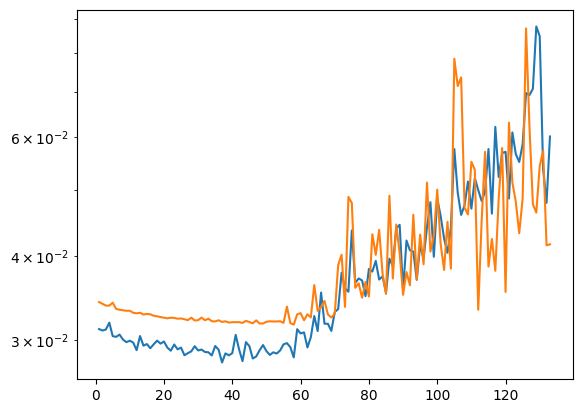

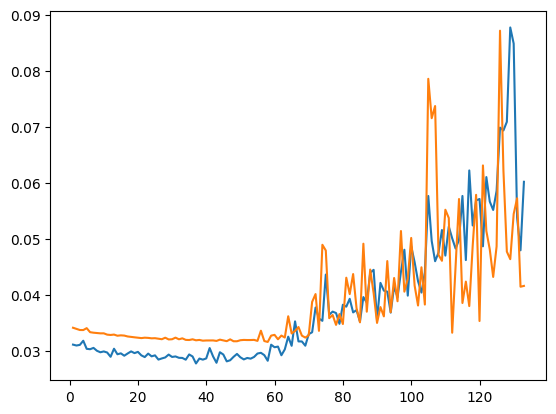

In [38]:


#black_loss = loss_func(torch.zeros(target.shape).to(device), target)
#black_loss_value = black_loss.item()
plt.plot(np.linspace(1, len(train_losses), len(train_losses)), train_losses)
plt.plot(np.linspace(1, len(val_losses), len(val_losses)), val_losses)
#plt.plot((0, len(losses)), (black_loss_value, black_loss_value))
#plt.plot(np.linspace(1, len(val_losses), len(val_losses)), val_losses)
plt.yscale("log")
plt.show()

plt.plot(np.linspace(1, len(train_losses), len(train_losses)), train_losses)
plt.plot(np.linspace(1, len(val_losses), len(val_losses)), val_losses)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

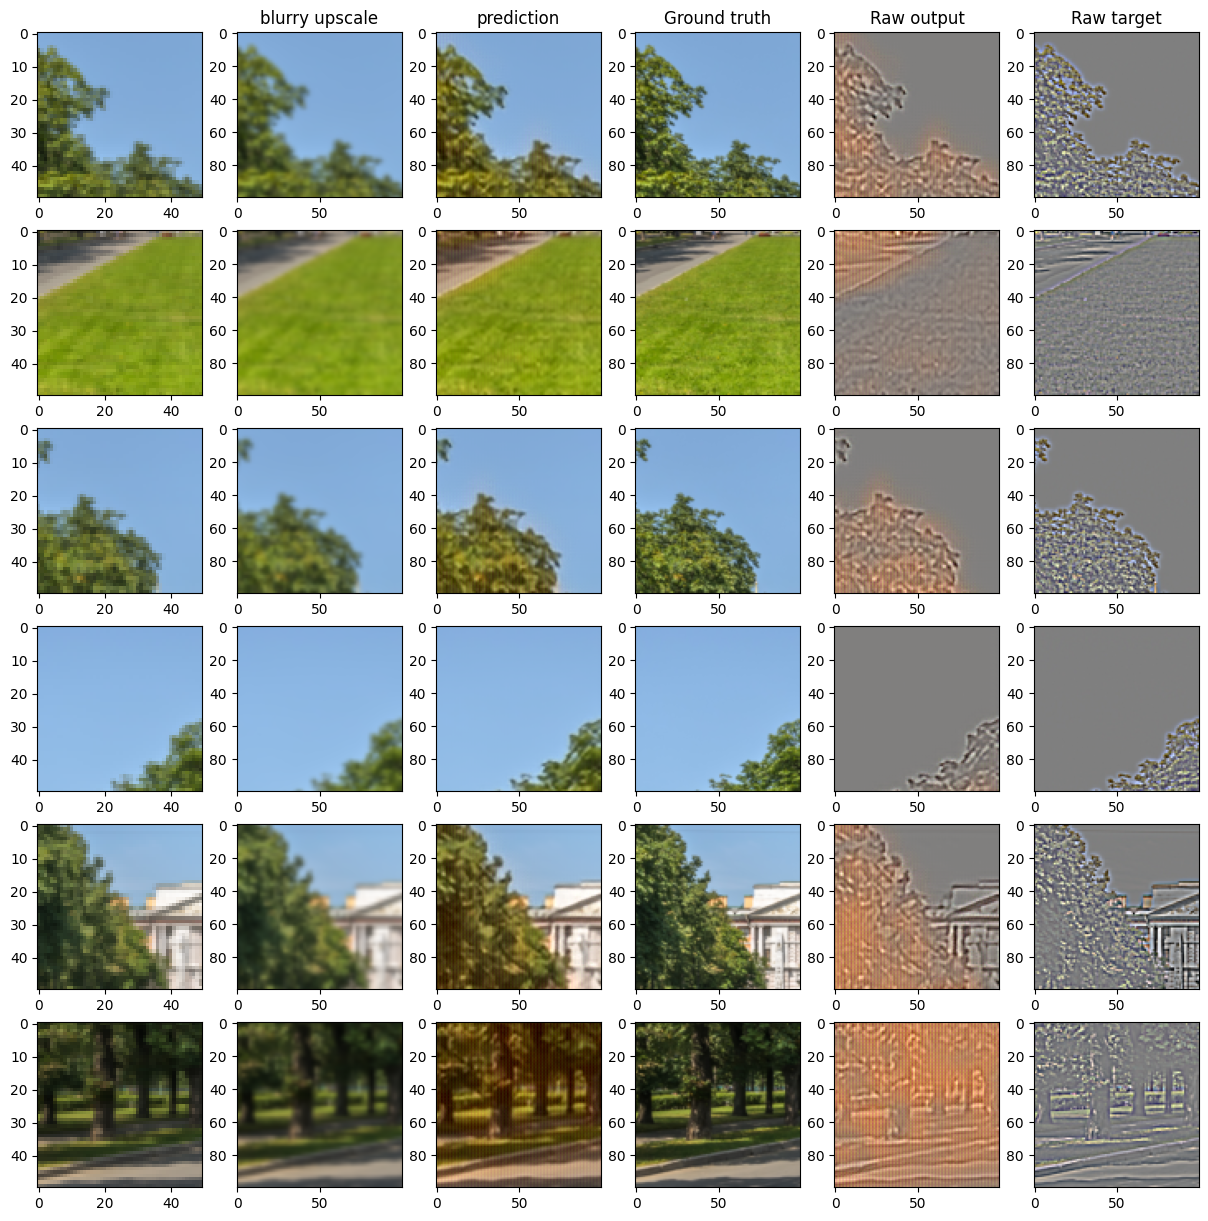

In [40]:
from visualization_tools import plot_upscaling
import random
import torchvision.transforms.v2 as transforms

train_pair = train_set[random.randint(0, len(train_set) - 1)]

val_pair = val_set[random.randint(0, len(val_set) - 1)]

plot_upscaling(val_pair, model)


In [71]:
torch.save(model, "PerspectiveNetRESBackbone64V1.pt")

In [79]:
hq_transform = RandomPartSelector(4096, 4096)
hq_dataset = SSDData("data", hq_transform, 0, 2)

model.to("cpu")

down_image, _ = hq_dataset[0]
model.eval()
upscaled_image = f.interpolate(down_image.unsqueeze(0), scale_factor=(2,2)) + model.forward(down_image).detach() / 2
#twice_upscaled_image = f.interpolate(upscaled_image, scale_factor=(2,2)) + model.forward(upscaled_image).detach() / 10

print(torch.max(upscaled_image))

plt.imshow(upscaled_image.cpu().squeeze(0).permute(1,2,0))

2


: 

In [58]:
to_pil_image = transforms.ToPILImage()

pil_image = to_pil_image(upscaled_image.clamp(0, 1).cpu().squeeze(0))
pil_image.save("output.png")

In [28]:
torch.save(model.state_dict(), "PerspectiveNetV2.pt")